In [1]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Preprocessor
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score,confusion_matrix,roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import RandomizedSearchCV

import pickle
import warnings

In [2]:
df = pd.read_csv('../data/Bank Customer Churn Prediction.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_cp = df.drop(columns=['churn'],axis=1)
df_cp = df.drop(columns=['customer_id'],axis=1)

In [5]:
df_cp

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Preprocessing

In [6]:
final_df = df_cp.copy()

In [7]:
final_df = pd.get_dummies(final_df,drop_first=True)

In [8]:
final_df

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0,1


In [9]:
X=final_df.drop('churn',axis=1)
X=X.drop('tenure',axis=1)
X=X.drop('products_number',axis=1)
X=X.drop('active_member',axis=1)
X.head()

,credit_score,age,balance,credit_card,estimated_salary,country_Germany,country_Spain,gender_Male
0,619,42,0.00,1,101348.88,0,0,0
1,608,41,83807.86,0,112542.58,0,1,0
2,502,42,159660.80,1,113931.57,0,0,0
3,699,39,0.00,0,93826.63,0,0,0
4,850,43,125510.82,1,79084.10,0,1,0


In [10]:
Y=final_df['churn']
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

In [11]:
X_bal,Y_bal=SMOTEENN().fit_resample(X,Y)

In [12]:
Y_bal.value_counts()

1    3567
0    2900
Name: churn, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal,Y_bal,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((5173, 8), (1294, 8))

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Model

In [15]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

Logistic Regression
Model performance for Training set
- Root Mean Squared Error: 0.4924
- Mean Absolute Error: 0.2424
- R2 Score: 0.0194
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.5065
- Mean Absolute Error: 0.2566
- R2 Score: -0.0352
- Accuracy Score: 0.7434


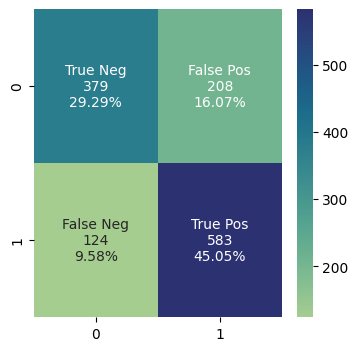

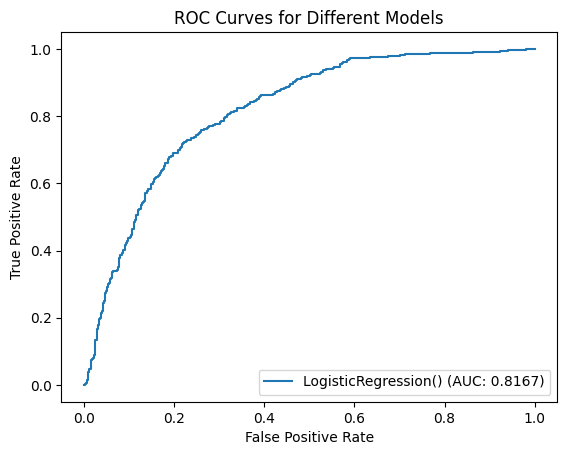

K-Neighbors Classifier
Model performance for Training set
- Root Mean Squared Error: 0.3977
- Mean Absolute Error: 0.1581
- R2 Score: 0.3603
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4677
- Mean Absolute Error: 0.2187
- R2 Score: 0.1176
- Accuracy Score: 0.7813


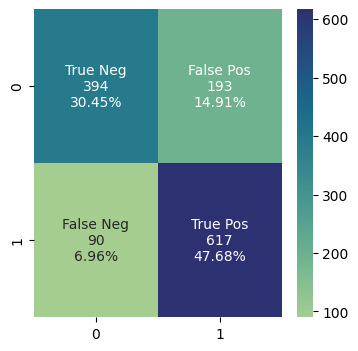

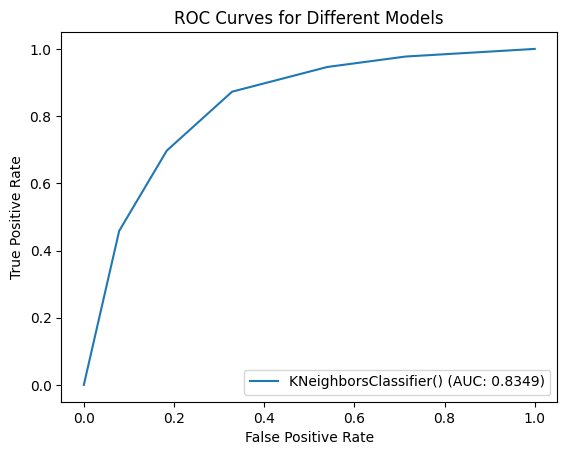

Decision Tree
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4693
- Mean Absolute Error: 0.2202
- R2 Score: 0.1114
- Accuracy Score: 0.7798


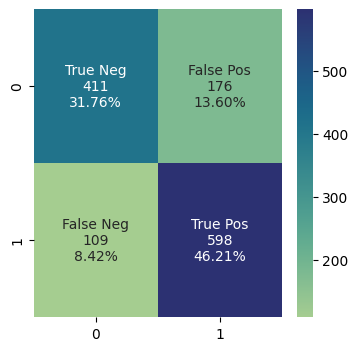

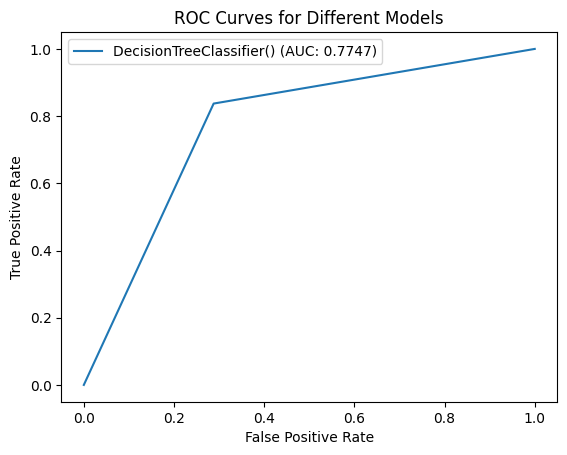

Random Forest Classifier
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4057
- Mean Absolute Error: 0.1646
- R2 Score: 0.3359
- Accuracy Score: 0.8354


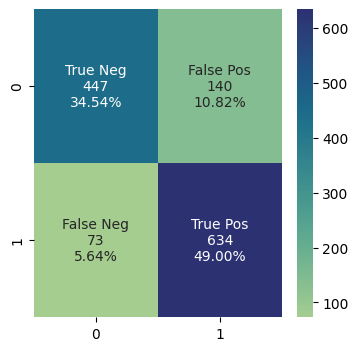

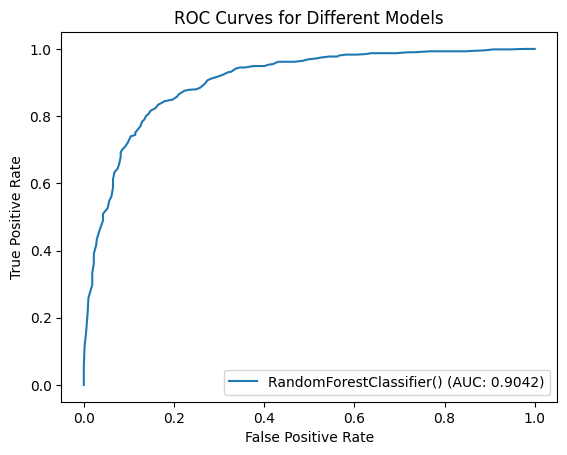

XGBClassifier
Model performance for Training set
- Root Mean Squared Error: 0.1267
- Mean Absolute Error: 0.0160
- R2 Score: 0.9351
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.3709
- Mean Absolute Error: 0.1376
- R2 Score: 0.4450
- Accuracy Score: 0.8624


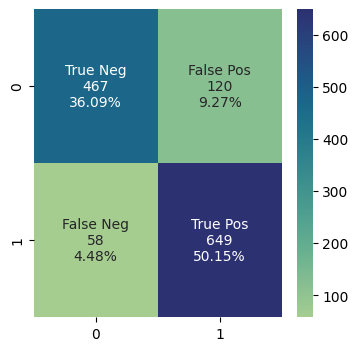

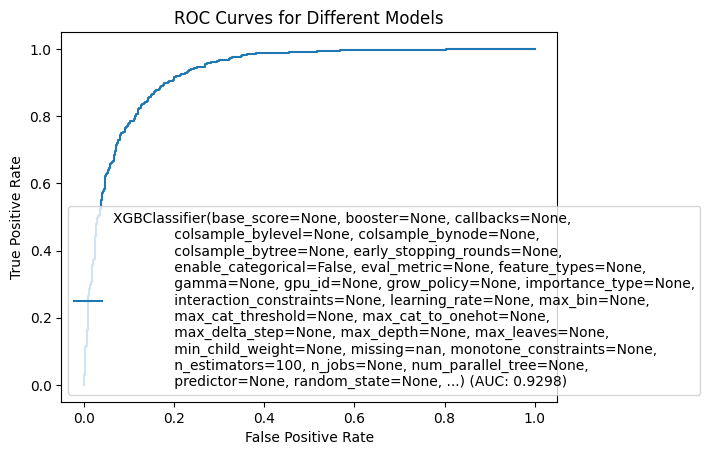

CatBoosting Classifier
Model performance for Training set
- Root Mean Squared Error: 0.3192
- Mean Absolute Error: 0.1019
- R2 Score: 0.5879
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4243
- Mean Absolute Error: 0.1801
- R2 Score: 0.2735
- Accuracy Score: 0.8199


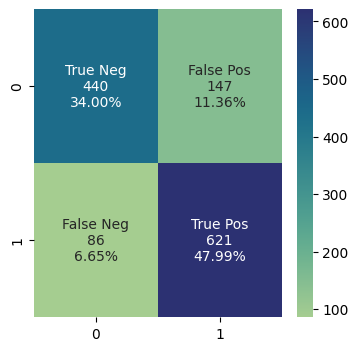

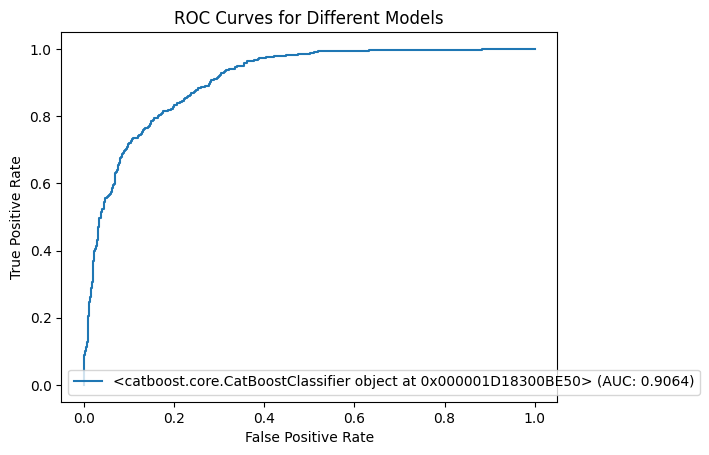

AdaBoost Classifier
Model performance for Training set
- Root Mean Squared Error: 0.4535
- Mean Absolute Error: 0.2057
- R2 Score: 0.1680
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4815
- Mean Absolute Error: 0.2318
- R2 Score: 0.0646
- Accuracy Score: 0.7682


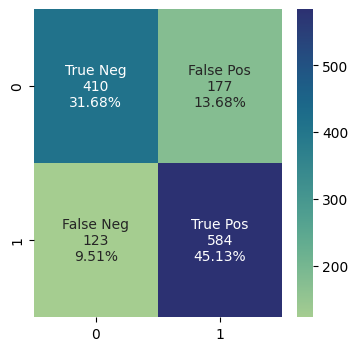

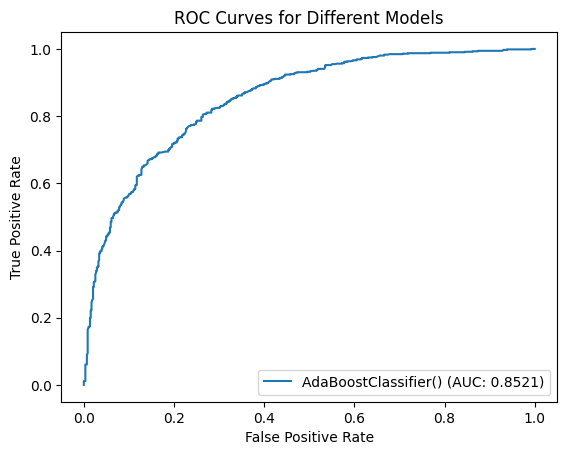

In [16]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": xgb(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}
model_list = []
r2_list =[]
acc_list = []

for i in range(len(list(models))):

    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    acc = accuracy_score(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("- Accuracy Score: {:.4f}".format(acc))
    r2_list.append(model_test_r2)
    acc_list.append(acc)
    conf_matrix = confusion_matrix(y_test,y_test_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='crest')
    plt.show()
    print('='*35)
    print('\n')
    model.fit(X_train, y_train)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Plot the curve with a unique label and color
    plt.plot(fpr, tpr, label=f"{model} (AUC: {roc_auc:.4f})")

# Add labels, title, and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Different Models")
    plt.legend()
    plt.show()

In [17]:
r2_score_df=pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=["R2 Score"],ascending=False)
r2_score_df

,Model Name,R2 Score
4,XGBClassifier,0.444995
3,Random Forest Classifier,0.335865
5,CatBoosting Classifier,0.273505
1,K-Neighbors Classifier,0.117605
2,Decision Tree,0.111369
6,AdaBoost Classifier,0.064599
0,Logistic Regression,-0.035178


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'XGBClassifier'),
  Text(1, 0, 'Random Forest Classifier'),
  Text(2, 0, 'CatBoosting Classifier'),
  Text(3, 0, 'K-Neighbors Classifier'),
  Text(4, 0, 'Decision Tree'),
  Text(5, 0, 'AdaBoost Classifier'),
  Text(6, 0, 'Logistic Regression')])

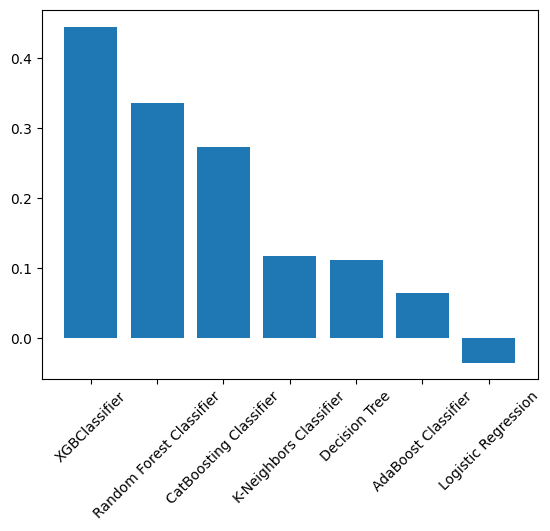

In [18]:
plt.bar(r2_score_df['Model Name'],r2_score_df['R2 Score'])
plt.xticks(rotation=45)

In [19]:
acc_score_df=pd.DataFrame(list(zip(model_list, acc_list)), columns=['Model Name', 'Accuracy Score']).sort_values(by=["Accuracy Score"],ascending=False)
acc_score_df

,Model Name,Accuracy Score
4,XGBClassifier,0.862442
3,Random Forest Classifier,0.835394
5,CatBoosting Classifier,0.819938
1,K-Neighbors Classifier,0.781298
2,Decision Tree,0.779753
6,AdaBoost Classifier,0.768161
0,Logistic Regression,0.743431


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'XGBClassifier'),
  Text(1, 0, 'Random Forest Classifier'),
  Text(2, 0, 'CatBoosting Classifier'),
  Text(3, 0, 'K-Neighbors Classifier'),
  Text(4, 0, 'Decision Tree'),
  Text(5, 0, 'AdaBoost Classifier'),
  Text(6, 0, 'Logistic Regression')])

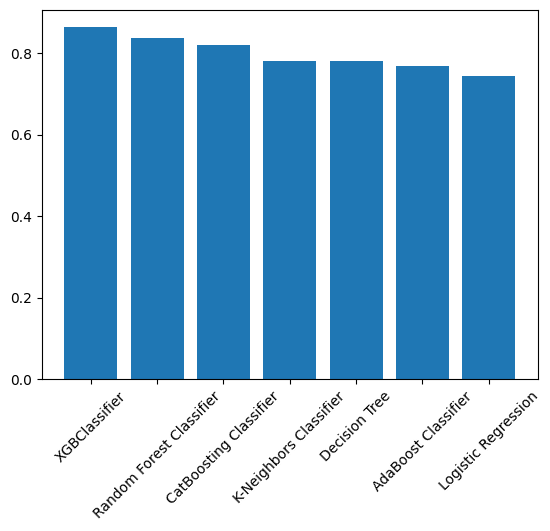

In [20]:
plt.bar(acc_score_df['Model Name'],acc_score_df['Accuracy Score'])
plt.xticks(rotation=45)

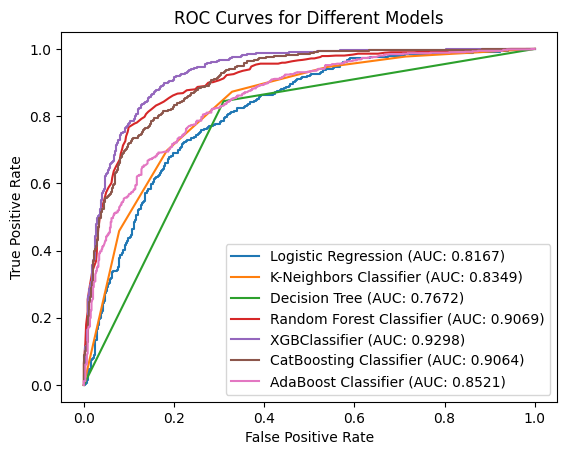

In [21]:
for model_name, model in models.items():
    # Train the model and get predictions
    model.fit(X_train, y_train)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    roc_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Plot the curve with a unique label and color
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {roc_auc:.4f})")

# Add labels, title, and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()

Random Search CV

In [22]:
# learning_rate=0.24,gamma=0.0,max_depth=6,colsample_bytree=0.5,min_child_weight=1,n_estimators=700,booster='gbtree'
xgb_model = xgb()
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
prediction = xgb_model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, prediction)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

Accuracy: 86.2442%


0.8624420401854714


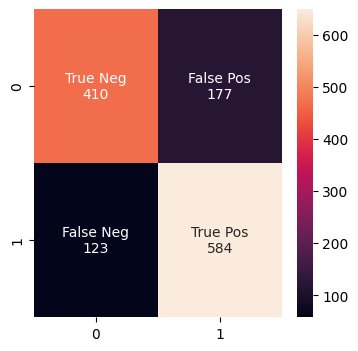

In [25]:
conf_matrix = confusion_matrix(y_test,prediction)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}" for v1,v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(4,4))
ax = sns.heatmap(conf_matrix, annot=labels, fmt='')
print(accuracy_score(y_test,prediction))

Applying Random Search CV

In [26]:

params = {
    'learning_rate' : (0.01, 0.5),
    'gamma' : (0.0, 0.5),
    'max_depth' : (3, 10),
    'colsample_bytree':(0.0, 0.3),
    'min_child_weight': (0, 6),
    'n_estimators' : (500, 1000)
}

In [27]:
random_search = RandomizedSearchCV(xgb_model,param_distributions=params,n_iter=20,cv=5,verbose=3)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.5, max_depth=3, min_child_weight=0, n_estimators=1000;, score=0.827 total time=   0.7s
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.5, max_depth=3, min_child_weight=0, n_estimators=1000;, score=0.837 total time=   0.8s
[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.5, max_depth=3, min_child_weight=0, n_estimators=1000;, score=0.834 total time=   0.9s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.5, max_depth=3, min_child_weight=0, n_estimators=1000;, score=0.823 total time=   0.7s
[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.5, max_depth=3, min_child_weight=0, n_estimators=1000;, score=0.806 total time=   0.7s
[CV 1/5] END colsample_bytree=0.3, gamma=0.5, learning_rate=0.5, max_depth=3, min_child_weight=6, n_estimators=1000;, score=0.803 total time=   0.7s
[CV 2/5] END colsample_bytree=0.3, gamma=0.5

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': (0.0, 0.3),
                                        'gamma': (0.0, 0.5),
                                        'learning_rate': (0.01, 0.5),
                                        'max_depth': (3, 10),
                                        'min_child_weight': (0, 6),
                                        'n_estimators': (500, 1000)},
                   verbose=3)

In [28]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
random_search.best_params_

{'n_estimators': 1000,
 'min_child_weight': 0,
 'max_depth': 10,
 'learning_rate': 0.5,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [30]:
xgb_model_rs = xgb(n_estimators= 1000,min_child_weight= 0,max_depth= 10,learning_rate = 0.5,gamma= 0.0,colsample_bytree= 0.3)
xgb_model_rs.fit(X_train,y_train)
pred_rs = xgb_model_rs.predict(X_test)
acc_rs = accuracy_score(y_test,pred_rs)
print(acc_rs)

0.8539412673879444


Bayesian Optimization

In [31]:
model_bo = xgb()
model_bo.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
warnings.filterwarnings('ignore')

In [33]:
pbounds = {
    'learning_rate': (0.01, 0.5),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (0, 1.0),
    'colsample': (0, 1.0),
    'gamma': (0, 5)}

In [34]:
from sklearn.model_selection import cross_val_score
def xgb_param(learning_rate,n_estimators,max_depth,subsample,colsample,gamma):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    clf = xgb(max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc'))

In [35]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(f=xgb_param,pbounds=pbounds,random_state=1)
optimizer.maximize(n_iter=100,init_points=10)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.869     | 0.417     | 3.602     | 0.01006   | 5.116     | 232.1     | 0.09234   |
| 2         | 0.8954    | 0.1863    | 1.728     | 0.2044    | 6.772     | 477.3     | 0.6852    |
| 3         | 0.8844    | 0.2045    | 4.391     | 0.02342   | 7.693     | 475.6     | 0.5587    |
| 4         | 0.9056    | 0.1404    | 0.9905    | 0.4024    | 9.778     | 382.1     | 0.6923    |
| 5         | 0.8705    | 0.8764    | 4.473     | 0.05167   | 3.273     | 252.8     | 0.8781    |
| 6         | 0.8943    | 0.09835   | 2.106     | 0.4794    | 6.732     | 722.7     | 0.3155    |
| 7         | 0.8872    | 0.6865    | 4.173     | 0.01896   | 8.251     | 990.0     | 0.7482    |
| 8         | 0.8825    | 0.2804    | 3.946     | 0.06058   | 6.135     | 917.7     | 0.2936    |
| 9         | 0.8912

Run the algorithm

In [36]:
optimizer.max

{'target': 0.9219702253179175,
 'params': {'colsample': 1.0,
  'gamma': 0.0,
  'learning_rate': 0.5,
  'max_depth': 5.595622106469538,
  'n_estimators': 626.2433274951808,
  'subsample': 1.0}}

In [37]:
xgb_model_bo = xgb(n_estimators= 1000,min_child_weight= 0,max_depth = 6,learning_rate = 0.29,gamma= 0.26,colsample_bytree= 0.49, subsample = 0.699)
xgb_model_bo.fit(X_train,y_train)
pred_bo = xgb_model_bo.predict(X_test)
acc_bo = accuracy_score(y_test,pred_bo)
# f_score = f_score(y_test,pred_bo)
print(acc_bo)


0.8585780525502318


Save to pickle model

In [38]:
# filename = 'model/model_rs.pkl'
# pickle.dump(xgb_model_rs, open(filename, 'wb'))

In [42]:
filename = 'model_bo1.pkl'
pickle.dump(xgb_model_bo,open(filename,'wb'))

Curves

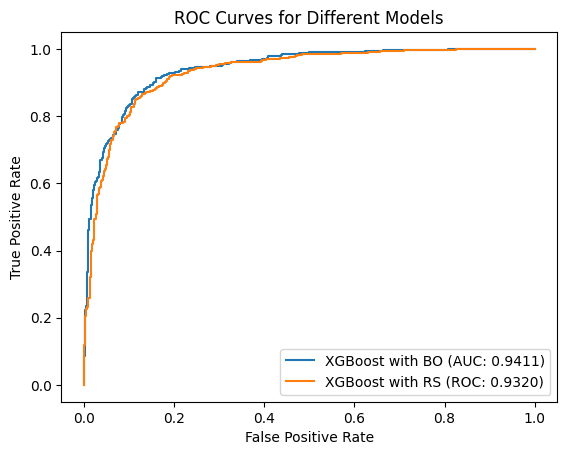

In [ ]:
xgb_model_bo.fit(X_train, y_train)
y_test_pred_proba_bo = xgb_model_bo.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_test_pred_proba_bo)
roc_auc1 = roc_auc_score(y_test, y_test_pred_proba_bo)
# Plot the curve with a unique label and color
plt.plot(fpr1, tpr1, label=f"XGBoost with BO (AUC: {roc_auc1:.4f})")


xgb_model_rs.fit(X_train, y_train)
y_test_pred_proba_rs = xgb_model_rs.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_test_pred_proba_rs)
roc_auc2 = roc_auc_score(y_test, y_test_pred_proba_rs)
# Plot the curve with a unique label and color
plt.plot(fpr2, tpr2, label=f"XGBoost with RS (ROC: {roc_auc2:.4f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()

In [ ]:
models = [xgb_model_bo,xgb_model_rs]
for model in models:
    print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.122, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_t